We want to test the performance of a QIF framework for non-Markovian, covariance stationary process using non-linear quantised measurements.

#### TRUE DYNAMICS

We will use AKF coefficients for the true test cases defined in the linear regime.

Linear Regime 1:
- true_rk_quant = 0.001^2
- QKF is fed AKF (optimal) sigma, R

Linear Regime 2:
- true_rk_quant = 0.001^2
- QKF is fed AKF (optimal) sigma
- OKF is fed true_rk_quant + AKF (optimal) R

In [1]:
q_regime=[]

#### PREAMBLE COMMANDS ####

In [2]:
import sys
sys.path.append('../../../')

#### Local QIF Filter and Helper Functions ####
from qif.qif import qif as qif
from qif.common import generate_AR, noisy_z, projected_msmt, qkf_state_err, normalise
from ls.common import doLSF_forecast

#### Local Plotting Tools ####
from plot_tools.fig_preamble import *
from plot_tools.plot_figstyle_sheet import STYLEDICT, COLOURDICT
from plot_tools.plot_helper_funcs import cm2inch

#### Matplotlib & Numpy ####
import numpy as np
import matplotlib as mpl
mpl.rc('font', size=8)
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import matplotlib.gridspec as gridspec


#### Global Plotting and Saving Commands ####

############ Saving Commands #########

ver=0
datapath = '../../DATA_v'+str(ver)+'_/' #v'+str(ver)+'/DATA_v'+str(ver)+'/'
savefig = './analysis_figs'
figname = 'tc_24_linear_regime_2_'

/home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:
/home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1182: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markeredgecolor != ec:


#### LOW Q REGIME - AR(2) PROCESS

We need to satisfy the following constraints 

For stationarity:
    (a) ph1 + ph2 < 1
    (b) ph1 - ph2 < 1
    (c) phi2| < 1

In [3]:
# ######## Covariance Stationary, MS Ergoic AR(2) Process#######
# # Stationary ARMA: http://matthieustigler.github.io/Lectures/Lect2ARMA.pdf

# ar1 = -0.02# 
# ar2 = +0.968
# q_regime.append(np.asarray([ar1, ar2]))

#### HIGH Q REGIME - AR(q) PROCESS USING LEARNED LSF WEIGHTS

In [4]:
# We want to load a high order AR(q) model where we know that underlyign truth is stationary.

from data_tools.load_raw_cluster_data import LoadExperiment

test_case = 24
variation_scan = [1, 2, 3, 4, 7]

#### Noise Parameters

In order to generate our true process, we will take tuned parameters from the linear AKF optimisation procedure. We retain an additional measurement noise term - which is white noise added prior to quantisation.

In [5]:
######## Msmt Noise Strength Prior to Quantisation
true_rk_quant = 0.001**2
####

#### Set up of Algorithm Parameters (QKF, LSF)

In [6]:
###### Number of data points and initial points to exclude (burnin) #####
num = 2050
burn_in = 0

###### AR Process Initialisation #####
# we need phases to accumulate from 0 to pi. So our process is no longer mean zero.
mean_noise = 0.5*np.pi

###### Bayes Risk Runs ######
runs = 50

########### LSF ##############
pick_alpha=0.1
n_predict = 50
n_train=num-n_predict
num_of_iterGD = 50

########### KF ##############
p0init = 1000 # set same as AKF /LSF

In [7]:
from scipy.signal import periodogram

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]

####  Run 100 times; with QKF using true dynamics and LSF learned dynamics

In [9]:
from data_tools.data_risk_analysis import riskmapdata, build_risk_dict

In [10]:
# riskmapexpt['AKF'][3]==experiment.AKF_macro_truth


In [11]:
norm_z_states_=[]

for idx_q_regime in xrange(len(variation_scan)):
    
    experiment = LoadExperiment(24, variation_scan[idx_q_regime], 
                                LKFFB_load ='No',
                                LSF_load='No',
                                AKF_load='Yes', 
                                AKF_path=datapath,
                                GPRP_load='No')
    
    # We extract tuned parameters from linear regimeto specify the dynamical model
    riskmapexpt = build_risk_dict(experiment)
    tuned_sigma, tuned_R = riskmapdata(riskmapexpt['AKF'][0], 
                                   riskmapexpt['AKF'][2], 
                                   riskmapexpt['AKF'][1],
                                   maxforecaststps=50,
                                   maxstateeststps=50)[0:2]
    
    print("Optimal KF pair from linear regime", tuned_sigma[0], tuned_R[0])
    
    # We make a truth bank of all f_n generated in the linear msmt regime
    shape = experiment.AKF_macro_truth.shape
    truth_bank = experiment.AKF_macro_truth.reshape(shape[0]*shape[1], shape[2]) # collapsed

    # We extract the the AR(q) regime of coefficients
    AKF_weights = experiment.AKF_weights
    order = AKF_weights.shape[0]
    n_start_at=n_train - order + 1

    # We store placeholders for analysis
    x_true_dynamics = np.zeros((runs, order, num))
    x_LSF_dynamics = np.zeros((runs, order, num))

    gain_true_dynamics = np.zeros((runs, order, num))
    gain_LSF_dynamics = np.zeros((runs, order, num))

    truths_ = np.zeros((runs, num))
    err_true_dynamics = np.zeros((runs, num))
    err_LSF_dynamics = np.zeros((runs, num))


    ######### Make an ensemble of QIF experiments ############

    for idx_run in xrange(runs):

        # Pick truth for one run
        pickone = int(np.random.uniform(low=0, high = int(truth_bank.shape[0]-1)))
        true_x = truth_bank[pickone, :] + mean_noise 
        truths_[idx_run, :] = true_x # this is mean 0.5 pi 
        
        # Our data set is a noisy f_n sequence which incurs a non linear msmt action + AGWN prior to quantisation 
        f_n_dataset = true_x + experiment.AKF_msmt_noise_variance*np.random.standard_normal(true_x.shape)
        noisy_z_ = noisy_z( f_n_dataset, true_rk_quant) # z is mean zero

        # Find LSF weights using quantised msmts
        measurements_train = projected_msmt(noisy_z_)
        measurements_val = projected_msmt(noisy_z_) # true_x doesnt change
        object_ = doLSF_forecast(measurements_train, measurements_val, pick_alpha, 
                           n_start_at, n_predict, order, 
                           steps_between_msmts=1, num_of_iterGD=num_of_iterGD)

        # Generate validation dataset
        y_signal = projected_msmt(noisy_z_)

        # Run QIF using AKF Dynamics 
        predictions, W, x_hat, P_hat, err_true_dynamics[idx_run, :] = qif('AKFdynamics', y_signal, 
                                                                          AKF_weights, 
                                                                          tuned_sigma[0], tuned_R[0] + true_rk_quant,
                                                                          n_train=n_train, 
                                                                          n_testbefore=n_predict, 
                                                                          n_predict=n_predict, 
                                                                          p0=p0init, skip_msmts=1,  save='No')
        # Run QIF using LSF Learned Dynamics 
        predictions_l, W_l, x_hat_l, P_hat_l, err_LSF_dynamics[idx_run, :] = qif('NEWdynamics', y_signal, 
                                                                                 object_[1][1].ravel() , 
                                                                                 tuned_sigma[0], tuned_R[0] + true_rk_quant, 
                                                                                 n_train=n_train, 
                                                                                 n_testbefore=n_predict, 
                                                                                 n_predict=n_predict, 
                                                                                 p0=p0init, 
                                                                                 skip_msmts=1, save='No')
        # Store run for this experiment
        x_true_dynamics[idx_run, :, :] = x_hat[:,0,:]
        x_LSF_dynamics[idx_run, :, :] = x_hat_l[:,0,:]

        gain_true_dynamics[idx_run, :, :] = W[:,0,:]
        gain_LSF_dynamics[idx_run, :, :] = W_l[:,0,:]

    ######### Calculate Bayes Risk with respect to z for each experiment ############

    z_true_dynamics = np.asarray([noisy_z(sequence, 0.) for sequence in x_true_dynamics[:, 0, 0:num]])
    z_LSF_dynamics = np.asarray([noisy_z(sequence, 0.) for sequence in x_LSF_dynamics[:, 0, 0:num]])

    ######### Calculate Bayes Risk for predicting mean z = 0.5cos(f_n) == 0  ############
    truths_z = np.asarray([noisy_z(sequence, 0.) for sequence in truths_[:, 0:num]])
    predict_one = np.mean((truths_z)**2, axis=0)

    ######### Normalise Bayes Risk  ############

    norm_z_states_.append([(qkf_state_err(z_true_dynamics[:, :], truths_z)) / predict_one, 
                      (qkf_state_err(z_LSF_dynamics[:, :], truths_z)) / predict_one])
    

AKF: Data Loaded? Yes
I am in RISK DICT and test case and variations are: 24 1
('Optimal KF pair from linear regime', 0.0037524869935435246, 3.3138177739302023e-05)
AKF: Data Loaded? Yes
I am in RISK DICT and test case and variations are: 24 2
('Optimal KF pair from linear regime', 0.262457340065538, 0.0067322345039353615)
AKF: Data Loaded? Yes
I am in RISK DICT and test case and variations are: 24 3
('Optimal KF pair from linear regime', 0.00047667030731105519, 9.2841378067634746e-08)
AKF: Data Loaded? Yes
I am in RISK DICT and test case and variations are: 24 4
('Optimal KF pair from linear regime', 0.0004214627027849767, 6.0364178214963457e-08)
AKF: Data Loaded? Yes
I am in RISK DICT and test case and variations are: 24 7
('Optimal KF pair from linear regime', 0.0077289266445570116, 3.9847495629040147e-06)


In [12]:
np.savez(datapath+'QIF_BayesPredRisk_v_OverSampl_v0_LinearRegime_2.npz', norm_z_states_=norm_z_states_)

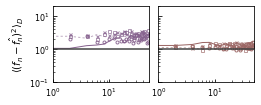

In [13]:
labels = [r'QKF(True $\Phi)$', r'QKF(AKF $\Phi$)', r'']
color = [COLOURDICT['QKF'], COLOURDICT['AKF']] # By algorithm
figstyl = ['-', 'o', 'x', 's', ':']  # By regime 


gs = gridspec.GridSpec(1, 2,
                       left=0.1, right=0.99, 
                       top=0.99, bottom=0.1, 
                       wspace=0.1, hspace=0.1)

fig = plt.figure(figsize=(cm2inch(8),cm2inch(3.)))
ax_0 = fig.add_subplot(gs[0, 0])
ax_1 = fig.add_subplot(gs[0, 1])



for idx_algo in xrange(2):
    
    for idx_q_regime in xrange(len(variation_scan)):
        
        alpha_gradient = 1.0 - 0.12*idx_q_regime
        
        vars()['ax_'+str(idx_algo)].plot(np.arange(0, n_predict, 2), 
                                   norm_z_states_[idx_q_regime][idx_algo][n_train : num : 2], 
                                   figstyl[idx_q_regime], 
                                   label=labels[idx_algo], 
                                   c=color[idx_algo],
                                   markeredgecolor=color[idx_algo],
                                   alpha=alpha_gradient,
                                   markerfacecolor="None", ms=3,lw=1)
        
    vars()['ax_'+str(idx_algo)].margins(0.2)
    vars()['ax_'+str(idx_algo)].set_yscale('log')
    vars()['ax_'+str(idx_algo)].set_xscale('log')
    vars()['ax_'+str(idx_algo)].axhline(y=1.0, c=COLOURDICT['TRUTH'])
    #vars()['ax_'+str(idx_algo)].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    #vars()['ax_'+str(idx_algo)].yaxis.set_minor_formatter(FormatStrFormatter('%.0f'))   
    vars()['ax_'+str(idx_algo)].tick_params(direction='in', which='both')
    vars()['ax_'+str(idx_algo)] = set_font_sizes(vars()['ax_'+str(idx_algo)], fsize, Fsize)
    #vars()['ax_'+str(idx_algo)].yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=2))
    vars()['ax_'+str(idx_algo)].set_ylim([0.1, 20])
    vars()['ax_'+str(idx_algo)].set_xlim([1, 50])

ax_0.set_ylabel(r'$\langle (f_n -\hat{f_n})^2 \rangle_D$')

ax_1.set_yticklabels('')


fig.savefig(savefig+figname+'.svg', format='svg', dpi=400)
plt.show()